# Finding the MRI brain tumor detection dataset

Let's find the dataset in this link: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

# Import packages

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys


tumor = []
healthy = []
for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)
    
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))    

## Reading the Images

In [42]:
healthy.shape

(116, 128, 128, 3)

In [43]:
tumor.shape

(168, 128, 128, 3)

In [44]:
np.random.choice(10, 5, replace=False)

array([7, 4, 8, 5, 1])

# Visualizing Brain MRI Images

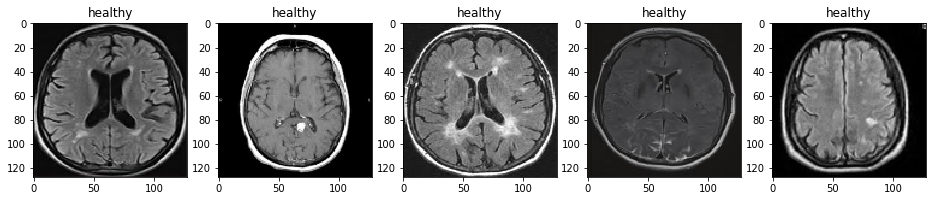

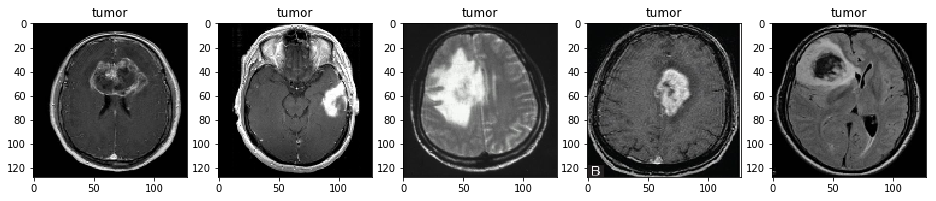

In [2]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])
        
        
plot_random(healthy, tumor, num=5)
    

 # Create Torch Dataset Class

## What is Pytorch's Abstract Dataset Class

In [3]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
    
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0    

## Creating MRI cutom dataset class 

In [4]:
mri_dataset = MRI()
mri_dataset.normalize()

# Creating a dataloader

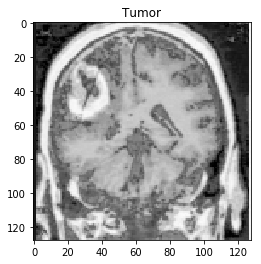

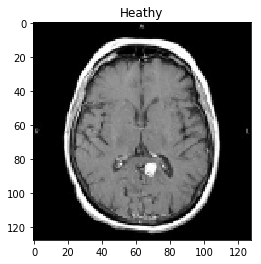

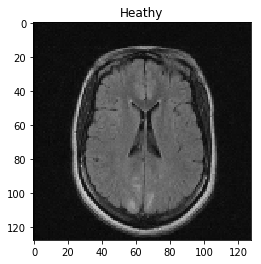

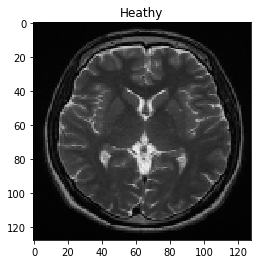

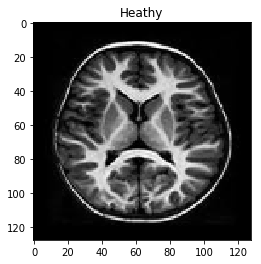

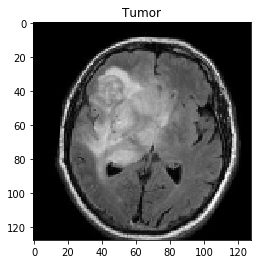

In [5]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

# Create a model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
            
    def predict(self, input_image):
        # Preprocess input_image (assuming input_image is a PIL Image or a NumPy array)
        # Perform necessary transformations such as resizing, normalization, and conversion to tensor
        # For example:
        # input_image = preprocess_input(input_image)

        # Convert input_image to tensor
        input_image_tensor = torch.tensor(input_image, dtype=torch.float32)

        # Add batch dimension (if input_image_tensor is not already batched)
        if len(input_image_tensor.shape) == 3:
            input_image_tensor = input_image_tensor.unsqueeze(0)

        # Make predictions
        with torch.no_grad():
            output = self.forward(input_image_tensor)
            predicted_class = torch.round(output).item()  # Assuming binary classification (0 or 1)
            return predicted_class                        

# Some Basics of Training and Evaluation in Pytorch

## model.eval()

- Used particularly for inference **NOTHING to DO with gradients!!!**
- changes the forward() behaviour of the module it is called up on eg, it disables dropout and has batch norm use the entire population statistics. This is necessary for inference

## model.train()

- Brings drop out and batch norm to action (i.e., train mode). 
- Gradients are computed

## numpy array vs tensor

The difference between a NumPy array and a tensor is that the tensors are backed by the accelerator memory like GPU and they are immutable, unlike NumPy arrays. You can never update a tensor but create a new one. If you are into machine learning or going to be into it, A Tensor is a suitable choice if you are going to use GPU. A tensor can reside in accelerator’s memory.

- The numpy arrays are the core functionality of the numpy package designed to support faster mathematical operations. Unlike python’s inbuilt list data structure, they can only hold elements of a single data type. Library like pandas which is used for data preprocessing is built around the numpy array. **Pytorch tensors are similar to numpy arrays, but can also be operated on CUDA-capable Nvidia GPU.**
- Numpy arrays are mainly used in typical machine learning algorithms (such as k-means or Decision Tree in scikit-learn) whereas pytorch tensors are mainly used in deep learning which requires heavy matrix computation.
- Unlike numpy arrays, while creating pytorch tensor, it also accepts two other arguments called the device_type (whether the computation happens on CPU or GPU) and the requires_grad (which is used to compute the derivatives).

## torch.tensor vs. torch.cuda.tensor

he key difference is just that torch.Tensor occupies CPU memory while torch.cuda.Tensor occupies GPU memory. Of course operations on a CPU Tensor are computed with CPU while operations for the GPU / CUDA Tensor are computed on GPU.

In [7]:
# device will be 'cuda' if a GPU is available
device = torch.device('cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.9157, 0.8710, 0.9520, 0.4064, 0.5374, 0.0735, 0.8867, 0.4991, 0.9744,
        0.4103]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.9157, 0.8710, 0.9520, 0.4064, 0.5374, 0.0735, 0.8867, 0.4991, 0.9744,
        0.4103]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.8385, 0.7586, 0.9063, 0.1652, 0.2888, 0.0054, 0.7863, 0.2491, 0.9495,
        0.1683])


As the underlying hardware interface is completely different, CPU Tensors are just compatible with CPU Tensor and vice versa GPU Tensors are just compatible to GPU Tensors.

### In which scenario is torch.cuda.Tensor() necessary?

When you want to use GPU acceleration (which is much faster in most cases) for your program, you need to use torch.cuda.Tensor, but you have to make sure that ALL tensors you are using are CUDA Tensors, mixing is not possible here.

### tensor.cpu().detach().numpy(): Convert Pytorch tensor to Numpy array

As mentioned before, np.ndarray object does not have this extra "computational graph" layer and therefore, when converting a torch.tensor to np.ndarray you must explicitly remove the computational graph of the tensor using the detach() command.
.cpu() returns a copy of this object in CPU memory.

# Evaluate a New-Born Neural Network!

In [8]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu:0')
model = CNN().to(device)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    


C:\Users\user\anaconda3\envs\MRI\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [9]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()


In [10]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [11]:
accuracy_score(y_true, threshold(outputs))

0.4169611307420495

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

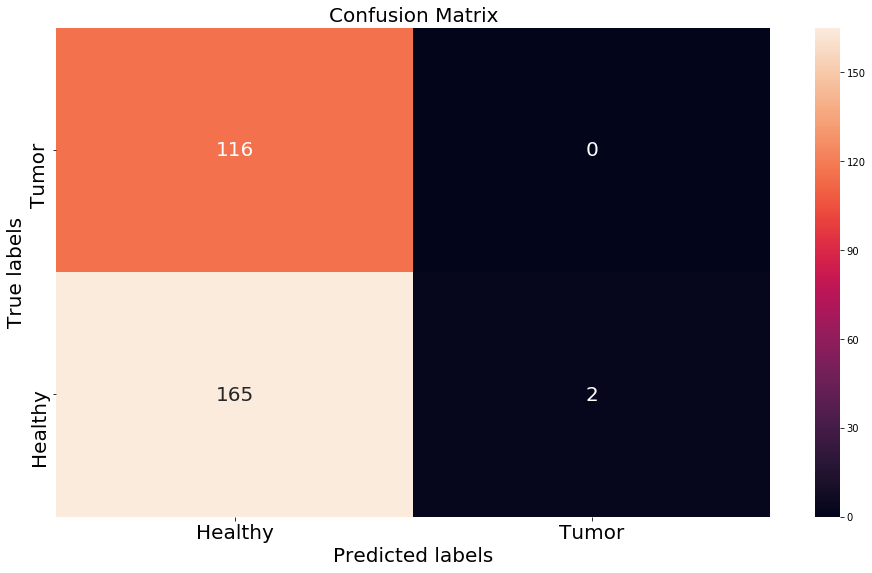

In [12]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

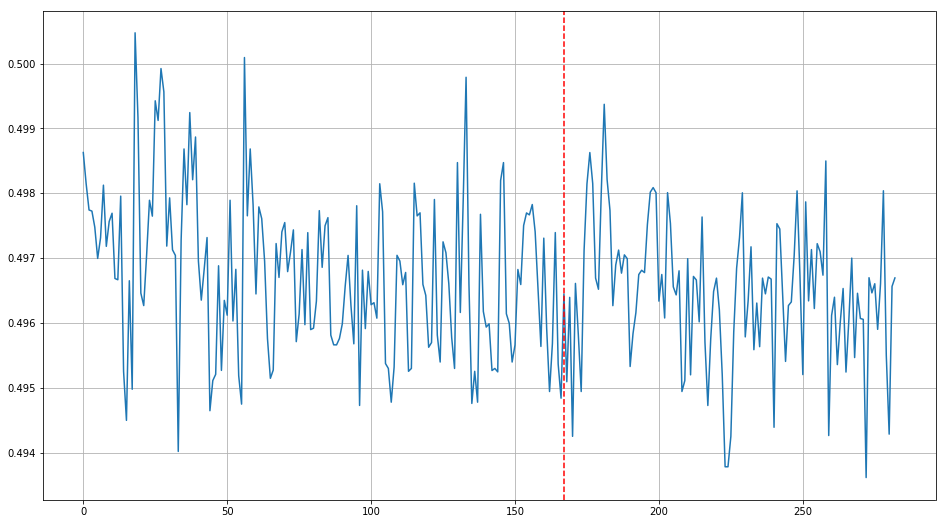

In [13]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Train the dumb model

In [14]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [15]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

C:\Users\user\anaconda3\envs\MRI\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 10	Loss: 0.622538
Train Epoch: 20	Loss: 0.554733
Train Epoch: 30	Loss: 0.538965
Train Epoch: 40	Loss: 0.527553
Train Epoch: 50	Loss: 0.514095
Train Epoch: 60	Loss: 0.501850
Train Epoch: 70	Loss: 0.483608
Train Epoch: 80	Loss: 0.458645
Train Epoch: 90	Loss: 0.434471
Train Epoch: 100	Loss: 0.413780
Train Epoch: 110	Loss: 0.396483
Train Epoch: 120	Loss: 0.369755
Train Epoch: 130	Loss: 0.346976
Train Epoch: 140	Loss: 0.327096
Train Epoch: 150	Loss: 0.306210
Train Epoch: 160	Loss: 0.285127
Train Epoch: 170	Loss: 0.277541
Train Epoch: 180	Loss: 0.249350
Train Epoch: 190	Loss: 0.234014
Train Epoch: 200	Loss: 0.207043
Train Epoch: 210	Loss: 0.187186
Train Epoch: 220	Loss: 0.170305
Train Epoch: 230	Loss: 0.147584
Train Epoch: 240	Loss: 0.132174
Train Epoch: 250	Loss: 0.110251
Train Epoch: 260	Loss: 0.091868
Train Epoch: 270	Loss: 0.077023
Train Epoch: 280	Loss: 0.059613
Train Epoch: 290	Loss: 0.049688
Train Epoch: 300	Loss: 0.041911
Train Epoch: 310	Loss: 0.031097
Train Epoch: 320	

# Evaluate a smart model

In [16]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [17]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

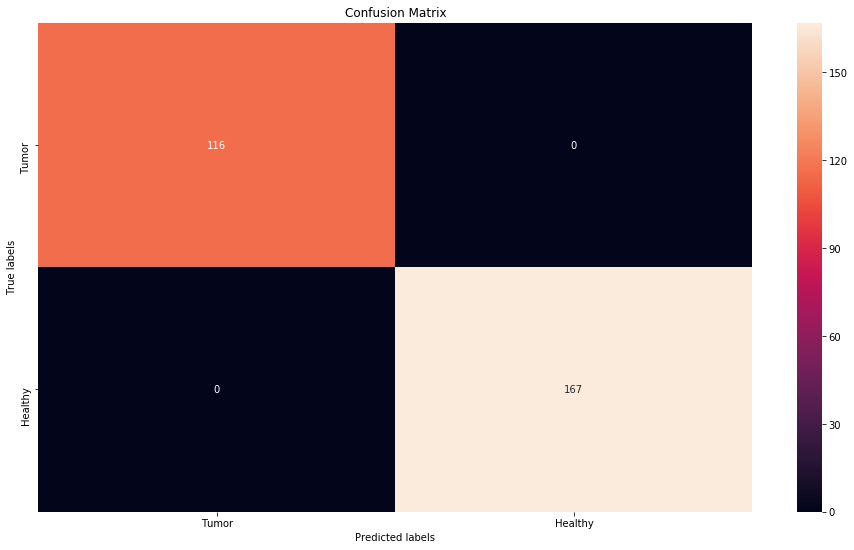

In [18]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

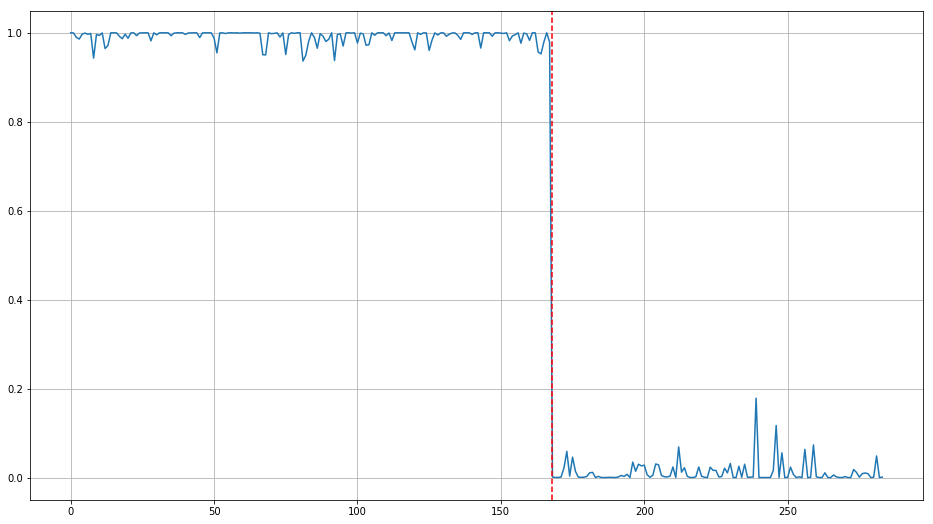

In [62]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Visualising the Feature Maps of the Convolutional Filters

In [93]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [19]:
no_of_layers = 0
conv_layers = []

In [20]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ), Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [21]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [130]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

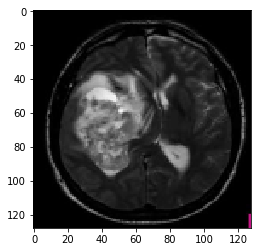

In [22]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [178]:
img = torch.from_numpy(img).to(device)

TypeError: expected np.ndarray (got Tensor)

In [179]:
img.shape

torch.Size([3, 128, 128])

In [180]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [181]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


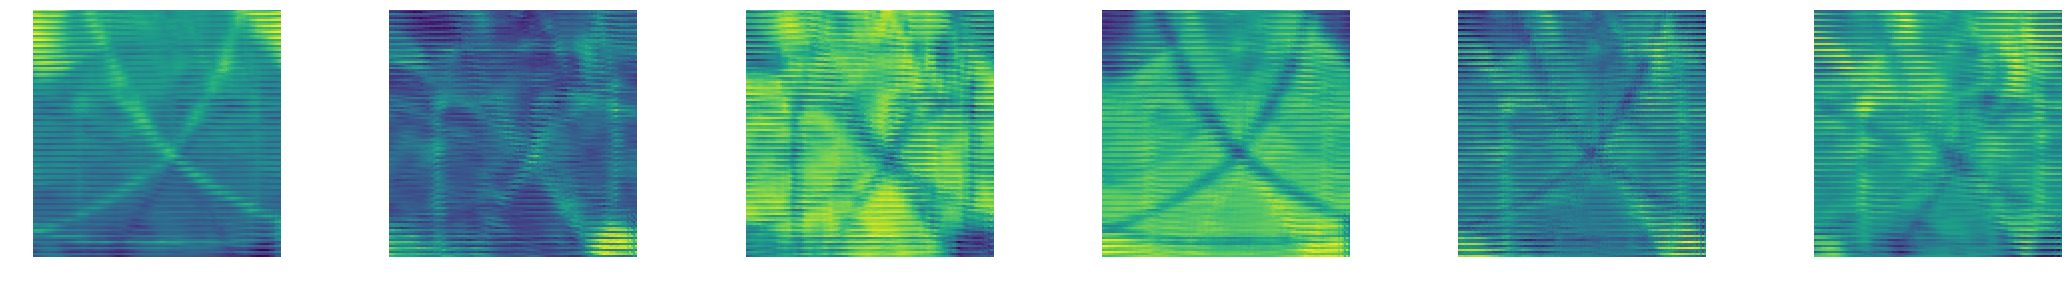

Layer  2


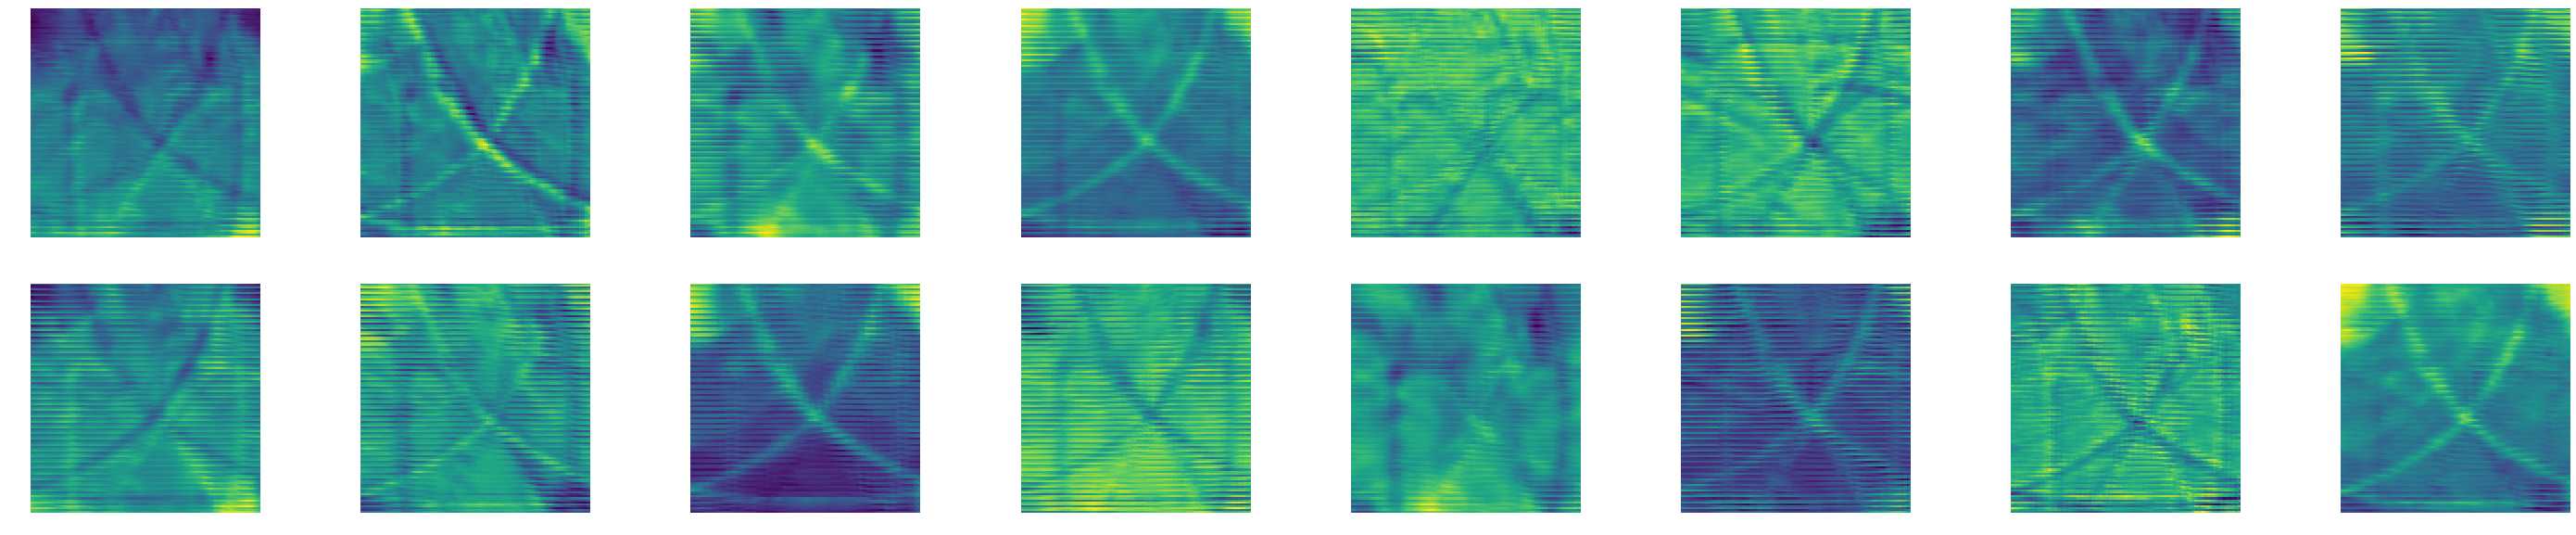

In [182]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

# Are We Over-fitting?

## Preparing a validation set: We need to change the MRI dataset slightly!

We will need to make changes to our **MRI dataset class**:

- Define a function to divide the data into train and validation sets
- Define a variable called **mode** to determine whether we are interested in the training OR validation data
- Change __len()__ and __getitem__() functions and conditioned over the variable **mode**

In [23]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

In [24]:
class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

# Are we overfitting?

In [25]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [26]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [27]:
device = torch.device("cpu:0")
model = CNN().to(device)

In [28]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [29]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [30]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

Train Epoch: 10	Train Loss: 0.643887	Val Loss: 0.670272
Train Epoch: 20	Train Loss: 0.624147	Val Loss: 0.640735
Train Epoch: 30	Train Loss: 0.552771	Val Loss: 0.611819
Train Epoch: 40	Train Loss: 0.558621	Val Loss: 0.599643
Train Epoch: 50	Train Loss: 0.504011	Val Loss: 0.594417
Train Epoch: 60	Train Loss: 0.501152	Val Loss: 0.616320
Train Epoch: 70	Train Loss: 0.546878	Val Loss: 0.598857
Train Epoch: 80	Train Loss: 0.437434	Val Loss: 0.601997
Train Epoch: 90	Train Loss: 0.429081	Val Loss: 0.612617
Train Epoch: 100	Train Loss: 0.408302	Val Loss: 0.654664
Train Epoch: 110	Train Loss: 0.410055	Val Loss: 0.646947
Train Epoch: 120	Train Loss: 0.387790	Val Loss: 0.646823
Train Epoch: 130	Train Loss: 0.359801	Val Loss: 0.669140
Train Epoch: 140	Train Loss: 0.335922	Val Loss: 0.685062
Train Epoch: 150	Train Loss: 0.331428	Val Loss: 0.690531
Train Epoch: 160	Train Loss: 0.335615	Val Loss: 0.704273
Train Epoch: 170	Train Loss: 0.301586	Val Loss: 0.710325
Train Epoch: 180	Train Loss: 0.341766	Va

Text(0, 0.5, 'Loss')

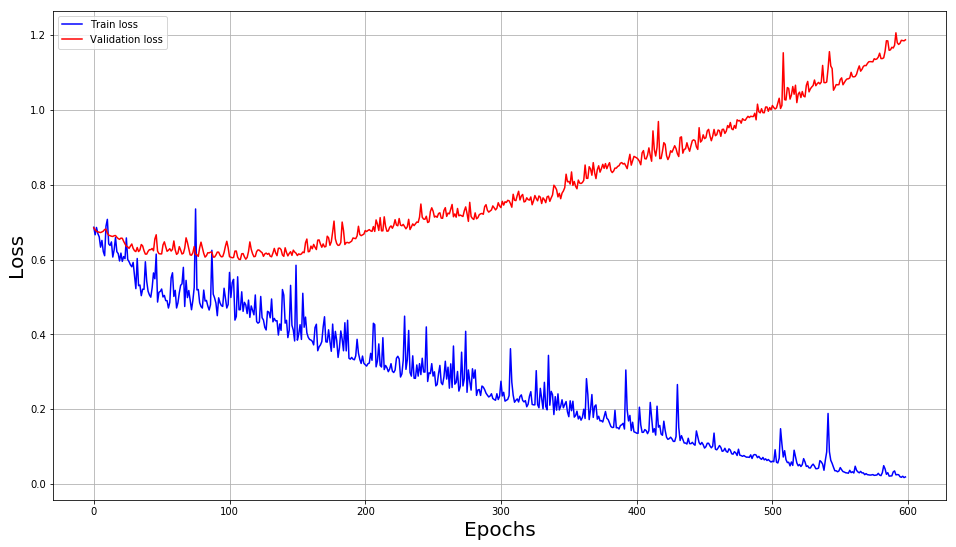

In [146]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Define your CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Create an instance of your CNN model
model = CNN()

# Load your dataset and split it into training and validation sets
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

# Define your data loaders for training and validation
train_loader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

# Define your training loop
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=100):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['image'], data['label']
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

# Define your optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Train your model
train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10)

Epoch 1, Loss: 0.6613826230168343
Epoch 2, Loss: 0.607151560485363
Epoch 3, Loss: 0.6931401714682579
Epoch 4, Loss: 0.6273448541760445
Epoch 5, Loss: 0.5781236477196217
Epoch 6, Loss: 0.5792016088962555
Epoch 7, Loss: 0.5604040771722794
Epoch 8, Loss: 0.5485972836613655
Epoch 9, Loss: 0.4630153961479664
Epoch 10, Loss: 0.4290170967578888


Tumor detected


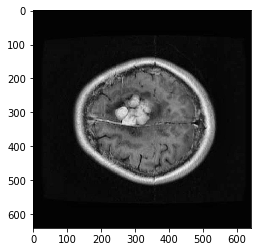

In [194]:
def predict_tumor(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.transpose(img, (2, 0, 1))  # Change image shape to (channels, height, width)
    img = torch.from_numpy(img).unsqueeze(0)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(img)
        prediction = torch.round(output).item()  # Round to 0 or 1
        if prediction == 1:
            return 'Tumor detected'
        else:
            return 'No tumor detected'

# Example usage
image_path = r'C:\Users\user\PycharmProjects\Brain_MRI_Tumor_detection\132_jpg.rf.16d894ca3458e53b1ab42b3e639857ab.jpg'
prediction = predict_tumor(model, image_path)
print(prediction)


input_image=cv2.imread(image_path)

plt.imshow(input_image)
plt.show()


In [31]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import torch

# Function to predict tumor
def predict_tumor(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.transpose(img, (2, 0, 1))  # Change image shape to (channels, height, width)
    img = torch.from_numpy(img).unsqueeze(0)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(img)
        prediction = torch.round(output).item()  # Round to 0 or 1
        if prediction == 1:
            return 'Tumor detected'
        else:
            return 'No tumor detected'

# Create Tkinter window
window = tk.Tk()
window.title("Brain Tumor Detection")

# Function to open file dialog and predict tumor
def open_file_dialog():
    file_path = filedialog.askopenfilename()
    if file_path:
        input_image = cv2.imread(file_path)
        prediction = predict_tumor(model, file_path)

        # Display image
        img = Image.open(file_path)
        img = img.resize((300, 300), Image.ANTIALIAS)
        img = ImageTk.PhotoImage(img)
        panel = tk.Label(window, image=img)
        panel.image = img
        panel.grid(row=1, column=0)

        # Display prediction
        result_label.config(text=prediction)

# Button to open file dialog
btn_open = tk.Button(window, text="Open Image", command=open_file_dialog)
btn_open.grid(row=0, column=0)

# Label to display prediction
result_label = tk.Label(window, text="")
result_label.grid(row=2, column=0)

# Start GUI
window.mainloop()


In [152]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Load and preprocess your data
tumor1 = []
healthy1 = []
for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor1.append(img.flatten())  # Flatten the image data

for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy1.append(img.flatten())  # Flatten the image data

healthy1 = np.array(healthy1)
tumor1 = np.array(tumor1)
All1 = np.concatenate((healthy1, tumor1))

# Create labels for the data
healthy_labels1 = np.zeros(healthy1.shape[0])
tumor_labels1 = np.ones(tumor1.shape[0])
labels1 = np.concatenate((healthy_labels1, tumor_labels1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(All1, labels1, test_size=0.2, random_state=42)

# Define your classifiers
knn = KNeighborsClassifier(n_neighbors=5)
logreg = LogisticRegression()
dt = DecisionTreeClassifier()

# Train the classifiers
knn.fit(X_train, y_train)
logreg.fit(X_train, y_train)
dt.fit(X_train, y_train)

# Make predictions on test data for each classifier
y_pred_knn = knn.predict(X_test)
y_pred_logreg = logreg.predict(X_test)
y_pred_dt = dt.predict(X_test)

# Calculate accuracy for each classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(f'KNN Accuracy: {accuracy_knn}')
print(f'Logistic Regression Accuracy: {accuracy_logreg}')
print(f'Decision Tree Accuracy: {accuracy_dt}')


C:\Users\user\anaconda3\envs\MRI\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


KNN Accuracy: 0.6666666666666666
Logistic Regression Accuracy: 0.7543859649122807
Decision Tree Accuracy: 0.6842105263157895
